In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 50
nA = 2
seed = get_current_seed()
#seed = 47146882006333120128184314011326542902
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
tmdp_1 = TMDP(river, xi, tau=.5, gamma=gamma, seed=seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Current seed for result reproducibility: 279775555245866238855708105127691260969


In [2]:
q_c = np.zeros((nS, nA))
tmdp.update_tau(.99)
cur_res = curriculum_AC(tmdp, q_c, alpha = 0.08, alpha_pol = 0.03, episodes=1500000, 
                        batch_nS=12, temperature=5., biased=False, lam=0, 
                        epochs=1, use_delta_Q=False, final_temperature=1)


No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 1170 length: 12 #teleports:1158
Time for bound evaluation:  1.4123165607452393
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 2634 length: 12 #teleports:1452
Time for bound evaluation:  0.005008220672607422
[(1, 0.99), (0.0, 0.98968), (1.0, 0.98968)]
Alpha*: 1.0 tau*: 0.98968 Episode: 4233 length: 12 #teleports:1587
Got not null reward 5.0!
Time for bound evaluation:  0.0050013065338134766
[(1, 0.98968), (0.0, 0.98935), (1.0, 0.98935)]
Alpha*: 1.0 tau*: 0.98935 Episode: 5606 length: 12 #teleports:1361
Got not null reward 5.0!
Time for bound evaluation:  0.011002540588378906
[(1, 0.98935), (0.0, 0.98902), (1.0, 0.98902)]
Alpha*: 1.0 tau*: 0.98902 Episode: 6959 length: 12 #teleports:1341
Time for bound evaluation:  0.004000663757324219
[(1, 0.98902), (0.0, 0.98869), (1.0, 0.98869)]
Alpha*: 1.0 tau*: 0.98869 Episode: 7863 length: 12 #teleports:892
Got not null reward 5.0!
Time for bound evaluation:  0.0

In [3]:
print(get_softmax_policy(cur_res["thetas"][-1]))
print(cur_res["Qs"][-1])
print(get_policy(cur_res["thetas"][-1]))

[[1.00000000e+00 1.21436807e-16]
 [1.00000000e+00 1.56155688e-14]
 [1.00000000e+00 6.42540243e-13]
 [1.00000000e+00 8.47330917e-12]
 [1.00000000e+00 2.73656513e-10]
 [9.99999996e-01 3.53818096e-09]
 [9.99999931e-01 6.90681937e-08]
 [9.99998920e-01 1.07988853e-06]
 [9.99990951e-01 9.04872668e-06]
 [9.99943885e-01 5.61146128e-05]
 [9.99615064e-01 3.84936289e-04]
 [9.98255753e-01 1.74424727e-03]
 [9.93157663e-01 6.84233705e-03]
 [9.82002055e-01 1.79979448e-02]
 [9.58774012e-01 4.12259878e-02]
 [9.20171009e-01 7.98289907e-02]
 [8.69249623e-01 1.30750377e-01]
 [8.16114803e-01 1.83885197e-01]
 [7.65255097e-01 2.34744903e-01]
 [7.08495571e-01 2.91504429e-01]
 [6.60649300e-01 3.39350700e-01]
 [6.25513567e-01 3.74486433e-01]
 [6.00494844e-01 3.99505156e-01]
 [5.76695303e-01 4.23304697e-01]
 [5.58080034e-01 4.41919966e-01]
 [5.44067272e-01 4.55932728e-01]
 [5.32353133e-01 4.67646867e-01]
 [5.23929080e-01 4.76070920e-01]
 [5.17886694e-01 4.82113306e-01]
 [5.13891816e-01 4.86108184e-01]
 [5.103026

In [4]:
res = bellman_optimal_q(mdp.env.P_mat, mdp.env.reward, mdp.gamma)
Q = res["Q"]
print(Q)
d = compute_d_from_tau(mdp.env.mu, mdp.env.P_mat, mdp.xi, get_policy(Q), mdp.gamma, 0.)
d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_softmax_policy(cur_res["thetas"][-1]), tmdp.gamma, 0.)
d_q = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(q_c), tmdp.gamma, 0.)

delta_pol = get_policy(Q)-get_policy(get_softmax_policy(cur_res["thetas"][-1]))
print(delta_pol)
V = compute_V_from_Q(Q, get_softmax_policy(cur_res["thetas"][-1]))
r_s_a = compute_r_s_a(mdp.env.P_mat, mdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, mdp.gamma)
j_curr = compute_j(r_s_a, get_policy(get_softmax_policy(cur_res["thetas"][-1])), d_curr, tmdp.gamma)
j_q_curr = compute_j(r_s_a, get_policy(q_c), d_q, tmdp.gamma)
j_exp = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)
print("expected performance: ",j_exp)
print("curriculum performance: ", j_curr)
print("Q curriculum performance: ",j_q_curr)

[[ 49.99999551  43.64999596]
 [ 44.99999596  39.73499632]
 [ 40.49999636  35.76149669]
 [ 36.44999673  32.18534702]
 [ 32.80499705  28.96681232]
 [ 29.52449735  26.07013109]
 [ 26.57204761  23.46311798]
 [ 23.91484285  21.11680618]
 [ 21.52335857  19.00512556]
 [ 19.37102271  17.10461301]
 [ 17.43392044  15.39415171]
 [ 15.6905284   13.85473653]
 [ 14.12147556  12.46926288]
 [ 12.709328    11.22233659]
 [ 11.4383952   10.10010293]
 [ 10.29455568   9.09009264]
 [  9.26510011   8.18108338]
 [  8.3385901    7.36297504]
 [  7.50473109   6.62667753]
 [  6.75425798   5.96400978]
 [  6.07883218   5.3676088 ]
 [  5.47094897   4.83084792]
 [  4.92385407   4.34776313]
 [  4.43146866   3.91298682]
 [  3.9883218    3.52168814]
 [  3.58948962   3.16951932]
 [  3.23054065   2.85256739]
 [  2.90748659   2.56731065]
 [  2.61673793   2.31057959]
 [  2.35506414   2.07952163]
 [  2.11955772   1.87156946]
 [  1.90760195   1.68441252]
 [  1.71684176   1.63806469]
 [  1.54515758   1.99735562]
 [  1.79762006

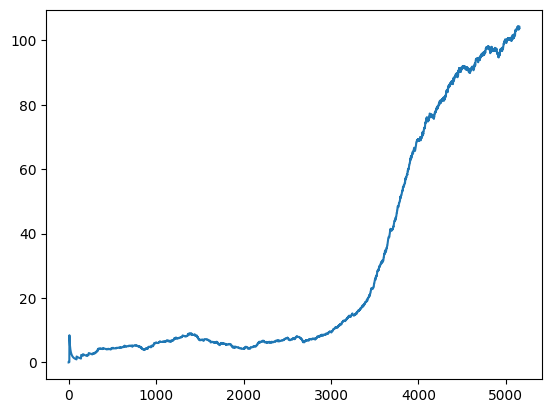

In [5]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 500:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-499:idx+1]
    average_reward.append(np.average(avg_list)/12)
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)